https://www.kaggle.com/mlg-ulb/creditcardfraud


> The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Libraries:
----------
- https://karateclub.readthedocs.io/en/latest/modules/root.html
- networkx - https://networkx.github.io/documentation

Reading materials:
------------------
- https://github.com/benedekrozemberczki/awesome-graph-classification

In [0]:
import pandas as pd

In [0]:
from sklearn.datasets import fetch_openml

In [0]:
X, y = fetch_openml(data_id=1597, return_X_y=True)

In [0]:
len(X)

284807

In [0]:
X.shape

(284807, 29)

In [0]:
import numpy as np

np.unique(y)

array(['0', '1'], dtype=object)

In [0]:
import seaborn as sns

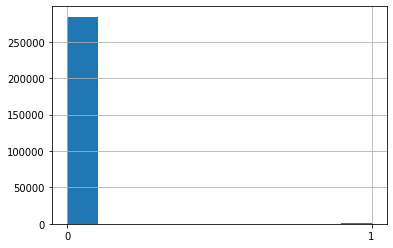

In [0]:
pd.Series(y).hist()

In [0]:
X.mean(axis=0)

array([ 1.16837498e-15,  3.41690805e-16, -1.37953671e-15,  2.07409512e-15,
        9.60406632e-16,  1.48731301e-15, -5.55646730e-16,  1.20549793e-16,
       -2.40630560e-15,  2.23885316e-15,  1.67332693e-15, -1.24701177e-15,
        8.19000127e-16,  1.20729421e-15,  4.88745586e-15,  1.43751637e-15,
       -3.74023697e-16,  9.56414917e-16,  1.03991661e-15,  6.40720156e-16,
        1.65656173e-16, -3.56859322e-16,  2.61058162e-16,  4.47306595e-15,
        5.21317980e-16,  1.68353699e-15, -3.65996607e-16, -1.22371013e-16,
        8.83496193e+01])

In [0]:
X.std(axis=0)

array([  1.95869237,   1.65130568,   1.51625234,   1.41586609,
         1.38024431,   1.33226875,   1.23709143,   1.19435081,
         1.09863016,   1.08884785,   1.02071124,   0.99919964,
         0.99527248,   0.95859393,   0.9153144 ,   0.87625135,
         0.84933557,   0.83817474,   0.81403907,   0.77092367,
         0.73452272,   0.72570029,   0.6244592 ,   0.605646  ,
         0.52127716,   0.48222617,   0.40363179,   0.33008268,
       250.11967014])

In [0]:
pip install dython

In [0]:
from dython.nominal import associations

feature correlations


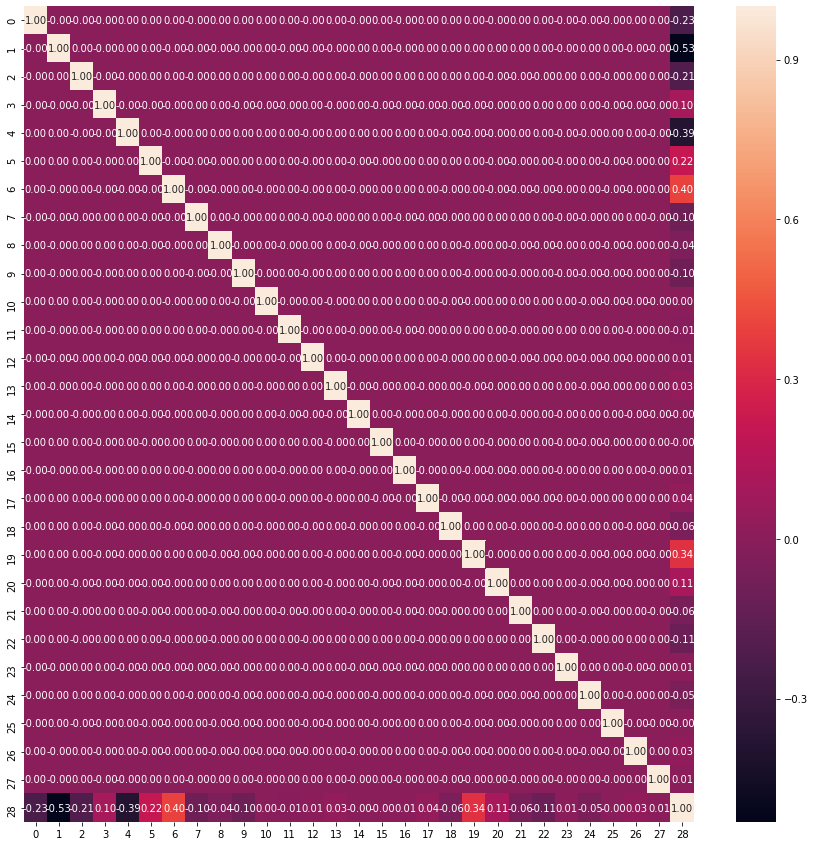

In [0]:
print('feature correlations')
associations(X, nominal_columns=None, return_results=False, figsize=[15, 15])

In [0]:
pip install annoy

     |████████████████████████████████| 645kB 2.8MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297343 sha256=4b2ad2315a04bf8bef1e925d7db182631066322a55e6910da1bf160fdcecec13
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [0]:
from annoy import AnnoyIndex
t = AnnoyIndex(X.shape[1], 'euclidean')  # Length of item vector that will be indexed
for i, v in enumerate(X):
    t.add_item(i, v)

t.build(10) # 10 trees


True

In [0]:
pip install mpld3

     |████████████████████████████████| 798kB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=76e00c56b559a25f38522475dd2ad00922e99e0be8b0459000b1db8c14e7d9cf
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


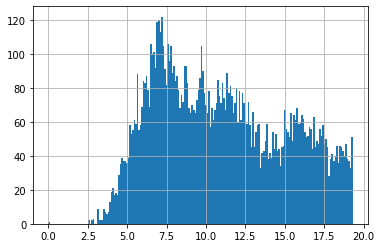

In [0]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

_, distances = t.get_nns_by_item(0, 10000, include_distances=True)
pd.Series(distances).hist(bins=200)

In [0]:
X.shape

(284807, 29)

In [0]:
from tqdm import trange
from scipy.sparse import lil_matrix

MAX_NEIGHBORS = 10000  # Careful: this parameter determines the run-time of the loop!
THRESHOLD = 6.0

def get_neighbors(i):
  neighbors, distances = t.get_nns_by_item(i, MAX_NEIGHBORS, include_distances=True)
  return [n for n, d in zip(neighbors, distances) if d < THRESHOLD]


n_rows = X.shape[0]
neighborhood = dict()
for i in trange(n_rows):
  neighborhood[i] = get_neighbors(i)

 42%|████▏     | 119170/284807 [29:15<48:59, 56.35it/s]

In [0]:
A = lil_matrix((n_rows, n_rows), dtype=np.int8)

for i, n in neighbors.items():
  A[i, n] = 1.0
  A[n, i] = 1.0

In [0]:
print('max sparsity given max neighbors parameter: {}'.format(MAX_NEIGHBORS / n_rows))

In [0]:
print('average number of connections: {}'.format(A.sum(axis=0).mean()))

In [0]:
print('sparsity: {}'.format(A.sum() / (n_rows * n_rows)))

In [0]:
# another attempt: I used the previous one in the experiment reported in the book
from numba import njit, jit, prange
import numpy as np
from numba.pycc import CC
from scipy.sparse import lil_matrix
from scipy.spatial.distance import cosine


cc = CC('adjacency_utils')

def angular(u, v):
  return np.sqrt(2 * (cosine(u, v)))

@cc.export('calc_dist', 'f8(f8[:], f8[:])')
@jit("f8(f8[:], f8[:])")
def calc_dist(u, v):
    '''Euclidean distance (without sqrt)
    Example:
    --------
    >> calc_dist(X[0, :], X[1, :])
    12.795783809844064
    '''
    d = u - v
    return np.sum(d * d)

@jit(nopython=False, parallel=True, forceobj=True)
def calculate_adjacency(X, threshold=0.5):
    '''Calculate an adjacency matrix
    given a feature matrix
    '''
    n_rows = X.shape[0]
    A = lil_matrix((n_rows, n_rows), dtype=np.int8)
    for i in prange(n_rows):
        for i2 in range(i+1, n_rows):
            d = calc_dist(X[i, :], X[i2, :])
            if d < threshold:
                A[i, i2] = 1.0
                A[i2, i] = 1.0
    return A

cc.compile()

# too slow, don't run!
#A = calculate_adjacency(X, threshold=threshold)

In [0]:
import networkx as nx
G = nx.from_scipy_sparse_matrix(A)

In [ ]:
from scipy.sparse.csgraph import connected_components
n_components, labels = connected_components(A, directed=False, return_labels=True)

In [0]:
len(dists)

In [0]:
nx.draw(G, with_labels=True, font_weight='bold')

In [0]:
t.get_distance(0, 64172)

In [0]:
t.get_distance(0, 212379)

In [0]:
transaction_correlations = associations(X.transpose(), nominal_columns=None, return_results=True)

In [0]:
correlations.shape

In [0]:
from scipy.spatial.distance import pdist
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html

In [0]:
correlations = pdist(X, metric='euclidean')

In [0]:
from sklearn.metrics import pairwise_distances

correlations = pairwise_distances(X, metric='euclidean')

In [0]:
correlations.shape

In [0]:
import networkx as nx

In [0]:
graph = nx.convert_matrix.from_pandas_edgelist(ata, "id_1", "id_2")